In [1]:
import torch
import pandas as pd
import numpy as np
import math

import textwrap

from typing import Optional
from diffusers import StableDiffusionPipeline
from huggingface_hub import notebook_login

import matplotlib.pyplot as plt
from PIL import Image
#from tensordict import TensorDict
from collections import defaultdict

notebook_login()

2025-12-10 18:50:53.866397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765392654.021755      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765392654.066790      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
pipe = StableDiffusionPipeline.from_pretrained(
    "Manojb/stable-diffusion-2-1-base", # "CompVis/stable-diffusion-v1-4",
    safety_checker=None,
    torch_dtype=torch.float16
).to("cuda")

model_index.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [151]:
def get_unet_resnets(pipe):
    resnets = {}
    
    for i, block in enumerate(pipe.unet.down_blocks):
        for j, resnet in enumerate(block.resnets):
            resnets[f"down_block_{i}_resnet_{j}"] = resnet

    for j, resnet in enumerate(pipe.unet.mid_block.resnets):
        resnets[f"mid_block_resnet_{j}"] = resnet

    for i, block in enumerate(pipe.unet.up_blocks):
        for j, resnet in enumerate(block.resnets):
            resnets[f"up_block_{i}_resnet_{j}"] = resnet

    return resnets


resnets = get_unet_resnets(pipe)
print(list(resnets.keys()))

['down_block_0_resnet_0', 'down_block_0_resnet_1', 'down_block_1_resnet_0', 'down_block_1_resnet_1', 'down_block_2_resnet_0', 'down_block_2_resnet_1', 'down_block_3_resnet_0', 'down_block_3_resnet_1', 'mid_block_resnet_0', 'mid_block_resnet_1', 'up_block_0_resnet_0', 'up_block_0_resnet_1', 'up_block_0_resnet_2', 'up_block_1_resnet_0', 'up_block_1_resnet_1', 'up_block_1_resnet_2', 'up_block_2_resnet_0', 'up_block_2_resnet_1', 'up_block_2_resnet_2', 'up_block_3_resnet_0', 'up_block_3_resnet_1', 'up_block_3_resnet_2']


In [5]:
dogs_dataset = pd.read_csv('/kaggle/input/prompts-steering/dogs.csv')

dog_prompts = dogs_dataset['positive'].tolist()
non_dog_prompts = dogs_dataset['negative'].tolist()

In [152]:
from typing import Optional

def collect_residual_streams(
    pipe: StableDiffusionPipeline,
    forget_set: list[str],
    retain_set: list[str],
    guidance: float,
    resnets: dict,
    layers: list[str],
    timesteps: list[int]
):
    forget_acts = []
    retain_acts = []

    for idx, (forget_prompt, retain_prompt) in enumerate(zip(forget_set, retain_set)):
        print(f'[{idx+1}] Extracting acts for forget prompt: {forget_prompt}')
        forget_act = get_unet_residual_stream(pipe, forget_prompt, guidance, resnets, layers, timesteps)

        print(f'[{idx+1}] Extracting acts for retain prompt: {retain_prompt}')
        retain_act = get_unet_residual_stream(pipe, retain_prompt, guidance, resnets, layers, timesteps)
        
        forget_acts.append(forget_act)
        retain_acts.append(retain_act)

    forget_layers = {}
    retain_layers = {}
    
    for l in layers:
        forget_layers[l] = torch.stack([f[l] for f in forget_acts], dim=0)
        retain_layers[l] = torch.stack([r[l] for r in retain_acts], dim=0)
        
    return forget_layers, retain_layers



def get_unet_residual_stream(
    pipe: StableDiffusionPipeline,
    prompt: str,
    guidance: float,
    resnets: dict,
    layers: list[str],
    timesteps: list[int]
):
    # designed to be simple, using batches would cause coherence issues when collecting acts.
    residuals_dict = {}
    handles = []

    current_step = 0

    def save_residuals(name):
        def hook(module, input, output):           
            if current_step in timesteps:
                # UNet calculates noise prediction for both conditioned and unconditioned input, so we take the second
                residual = output[1] if isinstance(output, tuple) else output
                residuals_dict.setdefault(name, []).append(residual[1].detach().cpu())

        return hook

    for l in layers:
        handles.append(
            resnets[l].register_forward_hook(save_residuals(l))
        )

    def callback(pipeline, step_index, timestep, callback_kwargs):
        nonlocal current_step
        current_step = step_index

        return callback_kwargs
    
    try:
        images = pipe(
            prompt,
            num_inference_steps=timesteps[-1],
            guidance_scale=guidance,
            callback_on_step_end=callback
        )
        
        return {
            layer: torch.stack(tensors, dim=0)
            for layer, tensors in residuals_dict.items()
        } # [T, C, H, W]
    except Exception as e:
        raise e
    finally:
        for h in handles:
            h.remove()

def show_images(images: list[Image.Image], prompts: list[str], cols: int = 2, width: int = 40) -> None:
    assert len(images) == len(prompts)

    rows = math.ceil(len(images) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))

    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]

    for ax in axes[len(images):]:
        ax.axis('off')

    for ax, img, prompt in zip(axes, images, prompts):
        ax.imshow(img)
        ax.axis('off')
        wrapped_prompt = "\n".join(textwrap.wrap(prompt, width=width))
        ax.text(0.5, -0.05, wrapped_prompt, fontsize=10, ha='center', va='top', transform=ax.transAxes)
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1)

    plt.tight_layout()
    plt.show()

**Extract raw activations and print layer names**

In [ ]:
#print(pipe.unet)
ALL_LAYERS = list(resnets.keys())
GUIDANCE = 7.5
LAYERS = ALL_LAYERS
STEPS = 30
TIMESTEPS = list(range(1, STEPS+1))

forget_acts, retain_acts = collect_residual_streams(
    pipe,
    dog_prompts[5:10],
    non_dog_prompts[5:10],
    guidance=GUIDANCE,
    resnets=resnets,
    layers=LAYERS,
    timesteps=TIMESTEPS
)

for layer, act in forget_acts.items():
    print(f'Layer {layer}: {act.shape}')

[1] Extracting acts for forget prompt: A playful golden retriever running in a sunny park, photorealistic


  0%|          | 0/30 [00:00<?, ?it/s]

[1] Extracting acts for retain prompt: A playful child running in a sunny park, photorealistic


  0%|          | 0/30 [00:00<?, ?it/s]

[2] Extracting acts for forget prompt: A group of dogs playing in the snow, winter scene, cinematic lighting


  0%|          | 0/30 [00:00<?, ?it/s]

[2] Extracting acts for retain prompt: A group of children playing in the snow, winter scene, cinematic lighting


  0%|          | 0/30 [00:00<?, ?it/s]

[3] Extracting acts for forget prompt: Close-up of a dog’s face, detailed fur and expressive eyes, portrait


  0%|          | 0/30 [00:00<?, ?it/s]

[3] Extracting acts for retain prompt: Close-up of a cat’s face, detailed fur and expressive eyes, portrait


  0%|          | 0/30 [00:00<?, ?it/s]

[4] Extracting acts for forget prompt: A dog catching a frisbee in mid-air, dynamic sports shot


  0%|          | 0/30 [00:00<?, ?it/s]

[4] Extracting acts for retain prompt: A boy catching a frisbee in mid-air, dynamic sports shot


  0%|          | 0/30 [00:00<?, ?it/s]

[5] Extracting acts for forget prompt: Watercolor painting of a happy dog in a garden, soft pastel colors


  0%|          | 0/30 [00:00<?, ?it/s]

[5] Extracting acts for retain prompt: Watercolor painting of a flower in a garden, soft pastel colors


  0%|          | 0/30 [00:00<?, ?it/s]

[6] Extracting acts for forget prompt: A dog running along the beach at sunset, golden hour lighting


  0%|          | 0/30 [00:00<?, ?it/s]

[6] Extracting acts for retain prompt: A person jogging along the beach at sunset, golden hour lighting


  0%|          | 0/30 [00:00<?, ?it/s]

[7] Extracting acts for forget prompt: A cartoon illustration of dogs having a birthday party, colorful


  0%|          | 0/30 [00:00<?, ?it/s]

[7] Extracting acts for retain prompt: A cartoon illustration of children having a birthday party, colorful


  0%|          | 0/30 [00:00<?, ?it/s]

[8] Extracting acts for forget prompt: A dog wearing a superhero costume, funny and cute style


  0%|          | 0/30 [00:00<?, ?it/s]

[8] Extracting acts for retain prompt: A cat wearing a superhero costume, funny and cute style


  0%|          | 0/30 [00:00<?, ?it/s]

[9] Extracting acts for forget prompt: A dog swimming in a lake, splashing water, realistic style


  0%|          | 0/30 [00:00<?, ?it/s]

[9] Extracting acts for retain prompt: A duck swimming in a lake, splashing water, realistic style


  0%|          | 0/30 [00:00<?, ?it/s]

[10] Extracting acts for forget prompt: Portrait of a dog sitting on a couch, cozy indoor scene


  0%|          | 0/30 [00:00<?, ?it/s]

[10] Extracting acts for retain prompt: Portrait of a child sitting on a couch, cozy indoor scene


  0%|          | 0/30 [00:00<?, ?it/s]

In [155]:
def compute_mean_differences(forget_layers_act, retain_layers_act):
    result = {}
    for (layer, X), (_, Y) in zip(forget_layers_act.items(), retain_layers_act.items()):
        result[layer] = (X - Y).mean(dim=(0, 3, 4)) # [T, C]
        
    return result


# Calculate steering vectors
steering_vectors = compute_mean_differences(forget_acts, retain_acts)

print([(layer, steering_vector.shape) for (layer, steering_vector) in steering_vectors.items()])

[('down_block_0_resnet_0', torch.Size([29, 320])), ('down_block_0_resnet_1', torch.Size([29, 320])), ('down_block_1_resnet_0', torch.Size([29, 640])), ('down_block_1_resnet_1', torch.Size([29, 640])), ('down_block_2_resnet_0', torch.Size([29, 1280])), ('down_block_2_resnet_1', torch.Size([29, 1280])), ('down_block_3_resnet_0', torch.Size([29, 1280])), ('down_block_3_resnet_1', torch.Size([29, 1280])), ('mid_block_resnet_0', torch.Size([29, 1280])), ('mid_block_resnet_1', torch.Size([29, 1280])), ('up_block_0_resnet_0', torch.Size([29, 1280])), ('up_block_0_resnet_1', torch.Size([29, 1280]))]


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

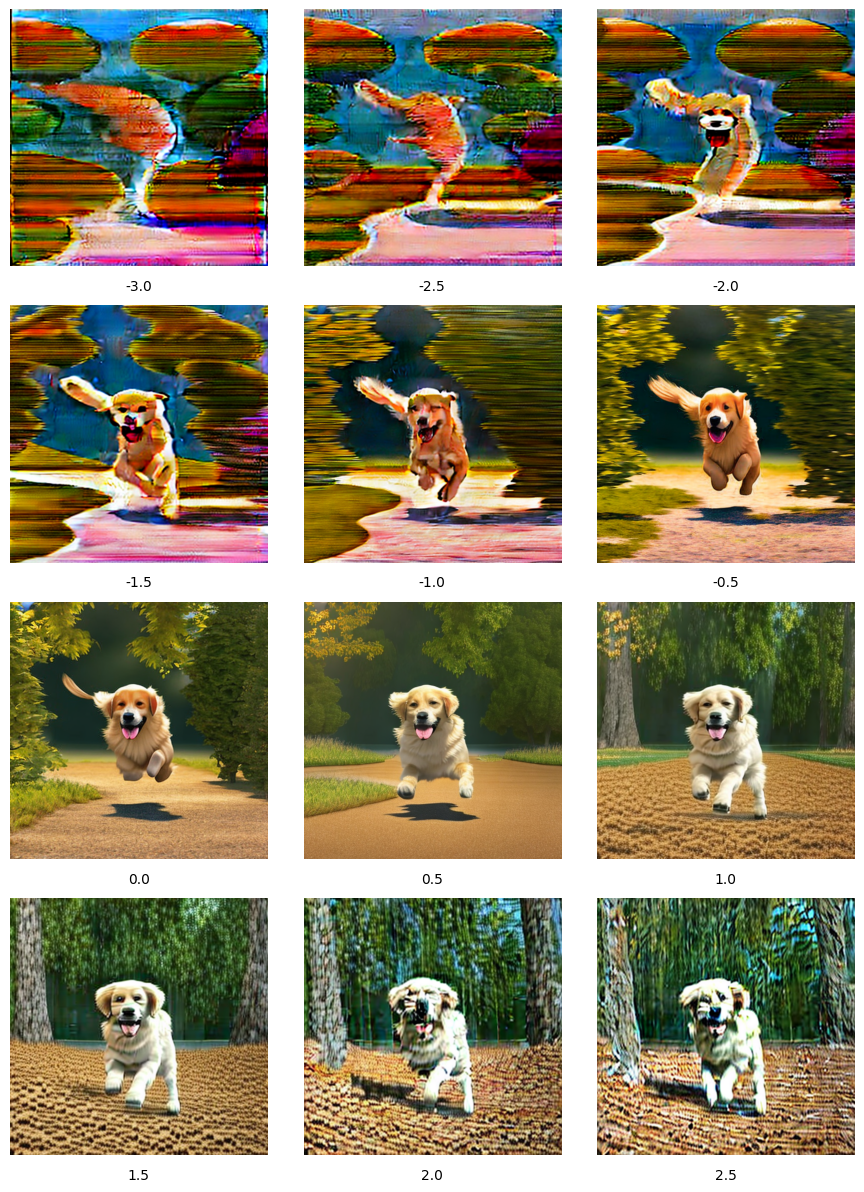

In [157]:
def steer_activations(x, r, lam=-1.0):
    # TODO: dot product
    #print(f'Steering on {x.shape} with {r.shape}')
    
    r = r.to(x.device, x.dtype)

    # x.ndim: 3 ([C,H,W]) or 4 ([1,C,H,W])
    # channel dimension is always 0 or 1
    if x.ndim == 3:  # [C,H,W]
        r = r[:, None, None]  # shape [C,1,1]
    elif x.ndim == 4:  # [1,C,H,W]
        r = r[None, :, None, None]  # shape [1,C,1,1]
    else:
        raise ValueError(f"Unsupported x.ndim {x.ndim}")

    return x + lam * r


def generate_with_steering(
    pipe: StableDiffusionPipeline,
    prompt: str,
    guidance: float,
    resnets: dict,
    steering_vectors: dict[str, torch.Tensor],
    timesteps: list[int],
    lam: float
):
    # designed to be simple, using batches would cause coherence issues when collecting acts.
    residuals_dict = {}
    handles = []

    current_step = 0

    def steering_hook(layer: str, steering_vector: torch.Tensor):
        ts_index = 0
        
        def hook(module, inp, out):
            nonlocal ts_index
            #print(f"[STEERING] layer={layer_name} step={current_step}")

            # out can be tensor or (hidden, tensor)
            if isinstance(out, tuple):
                hidden, residual = out
            else:
                hidden, residual = None, out  # residual: [B, C, H, W]

            if current_step in timesteps:
                #print(f'[{layer}] -> Step {current_step}, ts_index {ts_index}')
                
                x = residual[1]
                x_steered = steer_activations(x, steering_vector[ts_index], lam)
                residual[1] = x_steered
                
                ts_index += 1

            if hidden is None:
                return residual
            else:
                return (hidden, residual)

        return hook

    for layer, steering_vector in steering_vectors.items():
        handles.append(
            resnets[layer].register_forward_hook(steering_hook(layer, steering_vector))
        )

    def callback(pipeline, step_index, timestep, callback_kwargs):
        nonlocal current_step
        current_step = step_index

        return callback_kwargs
    
    try:
        return pipe(
            prompt,
            num_inference_steps=timesteps[-1],
            guidance_scale=guidance,
            callback_on_step_end=callback,
            generator=torch.Generator(device="cuda").manual_seed(546)
        ).images
    except Exception as e:
        raise e
    finally:
        for h in handles:
            h.remove()


# Run generation with steering
prompt = dog_prompts[0]

all_images = []
lambdas = []

for lam in torch.arange(-3, 3, 0.5):
    steered_images = generate_with_steering(
        pipe,
        prompt,
        GUIDANCE,
        resnets,
        steering_vectors,
        timesteps=TIMESTEPS,
        lam=lam,
    )
    all_images.extend(steered_images)
    lambdas.append(str(lam.item()))

# Visualize
show_images(all_images, lambdas, cols=3)